In [1]:
# !pip install CrowdTruth==2.0a1

import crowdtruth
from crowdtruth.configuration import DefaultConfig
import logging

relations = ["per:title", "per:founded_org", "per:place_of_birth", "per:children", "per:cause_of_death",
             "per:top_member_employee_of_org", "per:employee_or_member_of", "per:spouse","org:alternate_names",
             "org:subsidiaries", "per:place_of_death", "per:schools_attended", "org:place_of_headquarters",
             "per:charges", "per:origin", "per:places_of_residence", "none"]

def removeExtraRelations(annotation_separator, outputColumns, judgments):
    for col in outputColumns:
        judgments[col] = judgments[col].apply(lambda x: str(x).lower())

        # remove age relation from dataset
        judgments[col] = judgments[col].apply(lambda x: str(x).replace('per:age' + annotation_separator,''))
        judgments[col] = judgments[col].apply(lambda x: str(x).replace(annotation_separator + 'per:age', ''))
        judgments[col] = judgments[col].apply(lambda x: str(x).replace('per:age', 'none'))

        # merge personal and organizational alternate_names relation
        judgments[col] = judgments[col].apply(lambda x: str(x).replace('per:alternate_names', 'org:alternate_names'))
        judgments[col] = judgments[col].apply(lambda x: annotation_separator.join(
            sorted(str(x).split(annotation_separator))))
        judgments[col] = judgments[col].apply(lambda x: str(x).replace(
            'org:alternate_names' + annotation_separator + 'org:alternate_names', 'org:alternate_names'))
    return judgments

# Pre-process CF data

In [2]:
class ODRelExCF(DefaultConfig):
    inputColumns = ["sent_id", "relation", "term1", "b1", "e1", "term2", "b2", "e2", "sentence"]
    outputColumns = ["rellist"]
    
    open_ended_task = False
    annotation_vector = relations
    annotation_separator = "\n"
    
    def processJudgments(self, judgments):
        return removeExtraRelations(self.annotation_separator, self.outputColumns, judgments)

pre_processed_results_cf, config_cf = crowdtruth.load(
    directory = "data/input/CF",
    config = ODRelExCF()
)

# Pre-process AMT data

In [3]:
class ODRelExAMT(DefaultConfig):
    inputColumns = ["Input.sent_id", "Input.relation", "Input.term1", "Input.b1", "Input.e1",
                    "Input.term2", "Input.b2", "Input.e2", "Input.sentence"]
    outputColumns = ["Answer.Q1"]
    
    open_ended_task = False
    annotation_vector = relations
    annotation_separator = "|"
    
    def processJudgments(self, judgments):
        return removeExtraRelations(self.annotation_separator, self.outputColumns, judgments)

pre_processed_results_amt, config_amt = crowdtruth.load(
    directory = "data/input/AMT",
    config = ODRelExAMT()
)

# Merging the CF and AMT data

In [4]:
import pandas as pd

pre_processed_results_amt["units"] = pre_processed_results_amt["units"].rename(index=str, columns={
    "output.Q1": "output.rellist",
    "output.Q1.annotations": "output.rellist.annotations",
    "output.Q1.unique_annotations": "output.rellist.unique_annotations",
    "output.Q1.cos_clarity" : "output.rellist.cos_clarity"
})

pre_processed_results_amt["judgments"] = pre_processed_results_amt["judgments"].rename(index=str, columns={
    "output.Q1": "output.rellist",
    "output.Q1.agreement": "output.rellist.agreement",
    "output.Q1.count": "output.rellist.count"
})

pre_processed_results_amt["annotations"] = pre_processed_results_amt["annotations"].rename(index=str, columns={
    "output.Q1": "output.rellist"
})

pre_processed_results_amt["workers"] = pre_processed_results_amt["workers"].rename(index=str, columns={
    "output.Q1.count": "output.rellist.count"
})

pre_processed_results_cf["units"].index = pre_processed_results_cf["units"].index.map(str)
pre_processed_results_cf["judgments"].index = pre_processed_results_cf["judgments"].index.map(str)
pre_processed_results_cf["workers"].index = pre_processed_results_cf["workers"].index.map(str)
pre_processed_results_cf["judgments"]["worker"] = pre_processed_results_cf["judgments"]["worker"].astype(str)
pre_processed_results_cf["judgments"]["unit"] = pre_processed_results_cf["judgments"]["unit"].astype(str)

units = pd.concat([pre_processed_results_amt["units"], pre_processed_results_cf["units"]])
workers = pd.concat([pre_processed_results_amt["workers"], pre_processed_results_cf["workers"]])
annotations = pre_processed_results_amt["annotations"] + pre_processed_results_cf["annotations"]
# jobs = pd.concat([pre_processed_results_amt["jobs"], pre_processed_results_cf["jobs"]])
judgments = pd.concat([pre_processed_results_amt["judgments"], pre_processed_results_cf["judgments"]])

pre_processed_results = dict({
    "units": units,
    "workers": workers,
    "annotations": annotations,
    # "jobs": jobs,
    "judgments": judgments
})


# Run CrowdTruth metrics

In [7]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

processed_results = crowdtruth.run(pre_processed_results, config_cf)

INFO:root:1 iterations; max d= 1.0 ; wqs d= 0.607584589397; sqs d= 0.422460365045; rqs d= 0.454229636105
INFO:root:2 iterations; max d= 0.295776496159 ; wqs d= 0.0872371111618; sqs d= 0.040032064671; rqs d= 0.0810016563871
INFO:root:3 iterations; max d= 0.0568587830848 ; wqs d= 0.007116737541; sqs d= 0.00454941053537; rqs d= 0.00608209241058
INFO:root:4 iterations; max d= 0.0251943758598 ; wqs d= 0.00200821171388; sqs d= 0.00194049701459; rqs d= 0.00248822975036
INFO:root:5 iterations; max d= 0.00768981297441 ; wqs d= 0.000526066484498; sqs d= 0.000252662814321; rqs d= 0.000287271459532
INFO:root:6 iterations; max d= 0.00314015906254 ; wqs d= 0.000150305306915; sqs d= 0.000151261924074; rqs d= 0.000182876560432
INFO:root:7 iterations; max d= 0.00107596108603 ; wqs d= 5.69385823156e-05; sqs d= 1.82250242849e-05; rqs d= 1.95816611398e-05
INFO:root:8 iterations; max d= 0.000431071034489 ; wqs d= 1.59331012123e-05; sqs d= 1.58671975716e-05; rqs d= 1.76780881241e-05


# Visualize results

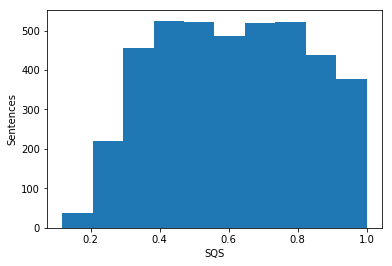

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(processed_results["units"]["uqs"])
plt.xlabel("SQS")
plt.ylabel("Sentences")

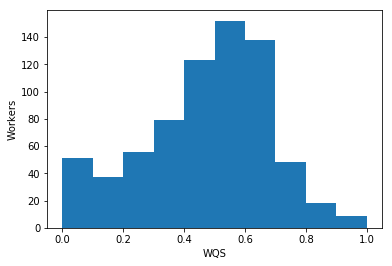

In [9]:
plt.hist(processed_results["workers"]["wqs"])
plt.xlabel("WQS")
plt.ylabel("Workers")

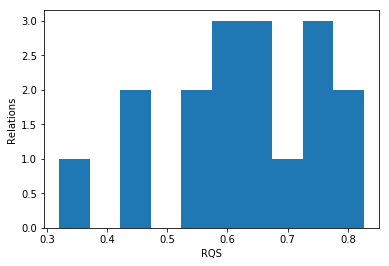

In [10]:
plt.hist(processed_results["annotations"]["aqs"])
plt.xlabel("RQS")
plt.ylabel("Relations")

In [11]:
processed_results["annotations"]["aqs"]

none                              0.643012
org:alternate_names               0.751063
org:place_of_headquarters         0.523684
org:subsidiaries                  0.563456
per:cause_of_death                0.640256
per:charges                       0.754334
per:children                      0.826448
per:employee_or_member_of         0.433378
per:founded_org                   0.602681
per:origin                        0.320858
per:place_of_birth                0.736751
per:place_of_death                0.633270
per:places_of_residence           0.441301
per:schools_attended              0.593899
per:spouse                        0.812712
per:title                         0.600642
per:top_member_employee_of_org    0.716412
Name: aqs, dtype: float64

# Save results

In [12]:
import operator

dlist = []
max_frame = []
max_fss = []
for idx in processed_results["units"].index:
    if idx != "unit_annotation_score":
        aux_dict = { k:v for k, v in processed_results["units"]["unit_annotation_score"][idx].iteritems() if v }
        dlist.append(aux_dict)
        max_frame.append(max(aux_dict.iteritems(), key=operator.itemgetter(1))[0])
        max_fss.append(max(aux_dict.values()))

processed_results["units"]["SRS"] = pd.Series(dlist, index=processed_results["units"].index)
processed_results["units"]["max_rel"] = pd.Series(max_frame, index=processed_results["units"].index)
processed_results["units"]["max_srs"] = pd.Series(max_fss, index=processed_results["units"].index)

for rel in relations:
    processed_results["units"][rel] = 0.0

for idx in processed_results["units"].index:
    for rel in relations:
        if rel in processed_results["units"]["SRS"][idx].keys():
            processed_results["units"].at[idx, rel] = max(0.0, processed_results["units"]["SRS"][idx][rel])

processed_results["units"].to_csv("data/output/aggregated_sentences.csv")
processed_results["workers"].to_csv("data/output/aggregated_workers.csv")

In [13]:
relations = list(pre_processed_results["annotations"].index)
for rel in relations:
    pre_processed_results["judgments"][rel] = 0.0
for idx in pre_processed_results["judgments"].index:
    for rel in relations:
        if rel in pre_processed_results["judgments"]["output.rellist"][idx].keys():
            pre_processed_results["judgments"].at[idx, rel] = max(
                0.0, pre_processed_results["judgments"]["output.rellist"][idx][rel])

pre_processed_results["judgments"].to_csv("data/output/worker_judgments.csv")